In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
import itertools

In [2]:
import warnings
warnings.filterwarnings(action='once')

In [3]:
bmb_serie = pd.read_csv(r"..\Datos\canasta_basica_serie.csv",index_col=0)

<AxesSubplot:>

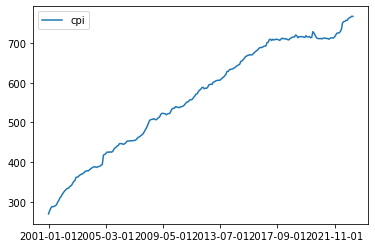

In [4]:
bmb_serie.columns = ['bmb']
bmb_serie.plot()

In [5]:
#Errors
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(list(np.array(forecast) - np.array(actual)))/np.abs(actual))  # MAPE
    me = np.mean(list(np.array(forecast) - np.array(actual)))             # ME
    mae = np.mean(np.abs(list(np.array(forecast) - np.array(actual))))    # MAE
    mpe = np.mean((list(np.array(forecast) - np.array(actual)))/np.array(actual))   # MPE
    rmse = np.mean(list(np.array(list(np.array(forecast) - np.array(actual)))**2))**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,'corr':corr})

In [6]:
def grid_search(degree, C_l,coef, eps, gamma, error):
    '''
    Grid search process to find optimal solution within a list of given parameters
    '''
    best_e=float('inf')
    test_y = bmb_serie[-tt-tv:-tv].bmb.tolist()

    for d in degree:
        print(d)
        for c in C_l:
            for co in coef:
                for ep in eps:
                    for g in gamma:
                        try:
                            model = SVR(kernel='poly', degree=d, C=c, cache_size=200, coef0=co, epsilon=ep, gamma=g,
            max_iter=100000000, shrinking=True, tol=0.001, verbose=False)
                            model.fit(x_train, y_train[:,0])

                            y_test_pred = model.predict(x_test).reshape(-1,1)

                            # Scaling the predictions
                            y_test_pred = scaler.inverse_transform(y_test_pred)

                            errors=forecast_accuracy([i[0] for i in y_test_pred], test_y)
                            e = errors[error]
                            if e<best_e:
                                opt_params = [d,c,co,ep,g]
                                best_e=e 
                                print(opt_params,best_e)
                        except:
                            print("Error")
                    
    print('BEST: ',opt_params, best_e)
    return opt_params

In [7]:
t =12
tt = 12
tv = 3

train= bmb_serie[:-tt-tv] #Reduced
test = bmb_serie[-tt-tv-t:-tv]
validation = bmb_serie[-tv-t:]


scaler = MinMaxScaler()

test_data = scaler.fit_transform(test)
train_data = scaler.transform(train)
val_data = scaler.transform(validation)

# Converting to numpy arrays
timesteps =t+1

train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
print(train_data_timesteps.shape)

test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
print(test_data_timesteps.shape)

val_data_timesteps=np.array([[j for j in val_data[i:i+timesteps]] for i in range(0,len(val_data)-timesteps+1)])[:,:,0]
print(val_data_timesteps.shape)

(240, 13)
(12, 13)
(3, 13)


In [8]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]
x_val, y_val = val_data_timesteps[:,:timesteps-1],val_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

(240, 12) (240, 1)
(12, 12) (12, 1)
(3, 12) (3, 1)


d1 = [2]
c1 = [0.01,0.1,0.5, 1,2,3]
coef1 = [0.001,0.01,0.1,1]
eps1 = [0.0001,0.001,0.01,0.1,1,2]
gamma1 = ['scale',1,2,10]

opt_params = grid_search(d1, c1,coef1, eps1, gamma1, 'mae')

In [9]:
model = SVR(kernel='poly', degree=2, C=3, coef0=0.1, epsilon=0.01, gamma=1,
                max_iter=100000000, cache_size=200, shrinking=True, tol=0.001, verbose=False)

model.fit(x_train, y_train[:,0])

y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)
y_val_pred = model.predict(x_val).reshape(-1,1)

# Scaling the predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)
y_val_pred = scaler.inverse_transform(y_val_pred)

C:\Users\MSI\anaconda3\envs\pyscience\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [10]:
x = forecast_accuracy([i[0] for i in y_train_pred], bmb_serie[t:-tt-tv].bmb.tolist())
print(x)
xt=forecast_accuracy([i[0] for i in y_test_pred], bmb_serie[-tt-tv:-tv].bmb.tolist())
print(xt)
xv=forecast_accuracy([i[0] for i in y_val_pred], bmb_serie[-tv:].bmb.tolist())
print(xv)

{'mape': 0.006886164102362271, 'me': 0.3380341891543902, 'mae': 3.4528996194469075, 'mpe': -0.0009008131320635281, 'rmse': 4.430331589820897, 'corr': 0.9996919585645561}
{'mape': 0.003666077315251072, 'me': -1.9309225227087268, 'mae': 2.7331071961768885, 'mpe': -0.0025779075818633287, 'rmse': 4.63575607782988, 'corr': 0.9596469135797346}
{'mape': 0.0014666327654516958, 'me': 0.7067088108005161, 'mae': 1.1234721828063055, 'mpe': 0.0009229952762056688, 'rmse': 1.1776285099903798, 'corr': 0.6264860302884081}


In [11]:
xtr = np.array([x_test[0]])
y_test_pred = []
for _ in range(tt):
    pred = model.predict(xtr).reshape(-1,1)
    xtr = np.array([np.concatenate((xtr[0],pred[0]))[1:]])
    y_test_pred.append(scaler.inverse_transform(pred)[0][0])

xvr = np.array([x_val[0]])
y_val_pred = []
for _ in range(tv):
    pred = model.predict(xvr).reshape(-1,1)
    xvr = np.array([np.concatenate((xvr[0],pred[0]))[1:]])
    y_val_pred.append(scaler.inverse_transform(pred)[0][0])
xt=forecast_accuracy(y_test_pred, bmb_serie[-tt-tv:-tv].bmb.tolist())
print(xt)

xv=forecast_accuracy(y_val_pred, bmb_serie[-tv:].bmb.tolist())
print(xv)

{'mape': 0.012400730814578353, 'me': -9.181229422405957, 'mae': 9.349642358755622, 'mpe': -0.012168538483397454, 'rmse': 11.379503018943929, 'corr': 0.9555959403268809}
{'mape': 0.0029174549480805423, 'me': 2.2360177967834716, 'mae': 2.2360177967834716, 'mpe': 0.0029174549480805423, 'rmse': 2.317604553140259, 'corr': 0.9998572709277966}


In [13]:
x_final = np.array([x_val[-1]])
y_final_pred = []
for i in range(9):
    pred = model.predict(x_final).reshape(-1,1)
    x_final = np.array([np.concatenate((x_final[0],pred[0]))[1:]])
    y_final_pred.append(scaler.inverse_transform(pred)[0][0])
y_final_pred

[765.9948549419913,
 764.7143435144872,
 768.7010916291417,
 769.9242850141677,
 771.6429432220054,
 773.3374022624221,
 774.3251863140259,
 776.0205002896394,
 777.3059046496725]

In [14]:
np.savetxt(r'..\Datos\svr_prediction.csv',np.array(y_final_pred), fmt = '%f', delimiter=",")   